In [14]:
import numpy as np
import pandas as pd
import random
import math

import os
from pathlib import Path
import shutil

import cv2
from tqdm import tqdm

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio, display, Image
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
import soundfile as sf

In [15]:
metadata_path = '../data/metadata/metadata.csv'
metadata = pd.read_csv(metadata_path)
mix_paths = metadata['npy_filename'].values

In [17]:
def clip(spectrogram, max_frames):
        """Clip time dimension of original spectrogram to max_frames. Pad if spectrogram is shorter than max_frames"""
        n_mels, time_dim = spectrogram.shape
        if time_dim > max_frames:
            spectrogram = spectrogram[:, :max_frames]
        elif time_dim < max_frames:
            pad_width = max_frames - time_dim
            spectrogram = np.pad(spectrogram, ((0,0), (0, pad_width)), mode='constant')

        return spectrogram

#### Visualize mixup Augmentation

{'African Paradise Flycatcher': 0, 'African Pipit': 1, 'African Reed Warbler': 2, 'African Rock Pipit': 3, 'Bar-throated Apalis': 4, 'Black Cuckoo': 5, 'Black-backed Puffback': 6, 'Black-headed Oriole': 7, 'Bokmakierie': 8, 'Cape Batis': 9, 'Cape Bunting': 10, 'Cape Robin-Chat': 11, 'Cape White-eye': 12, 'Chestnut-vented Warbler': 13, 'Chorister Robin-Chat': 14, 'Crested Barbet': 15, 'Dark-capped Bulbul': 16, 'Eastern Clapper Lark': 17, 'Fiery-necked Nightjar': 18, 'Fork-tailed Drongo': 19, 'Green Wood Hoopoe': 20, 'Green-backed Camaroptera': 21, 'Karoo Prinia': 22, 'Karoo Scrub Robin': 23, 'Levaillants Cisticola': 24, 'Long-billed Crombec': 25, 'Olive Bushshrike': 26, 'Orange-breasted Bushshrike': 27, 'Rattling Cisticola': 28, 'Red-chested Cuckoo': 29, 'Ring-necked Dove': 30, 'Rufous-naped Lark': 31, 'Sabota Lark': 32, 'Sombre Greenbul': 33, 'Southern Boubou': 34, 'Southern Double-collared Sunbird': 35, 'Tawny-flanked Prinia': 36, 'White-bellied Sunbird': 37, 'White-browed Robin-Chat'

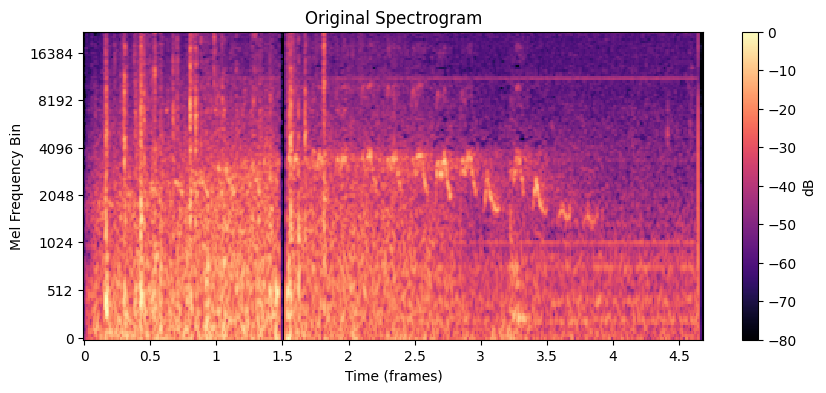

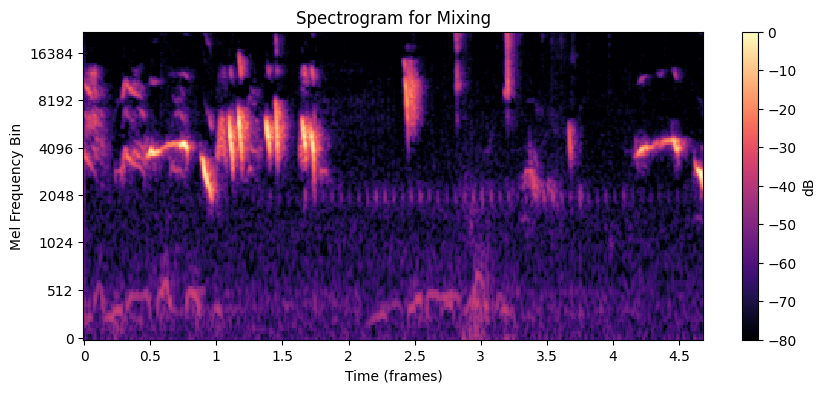

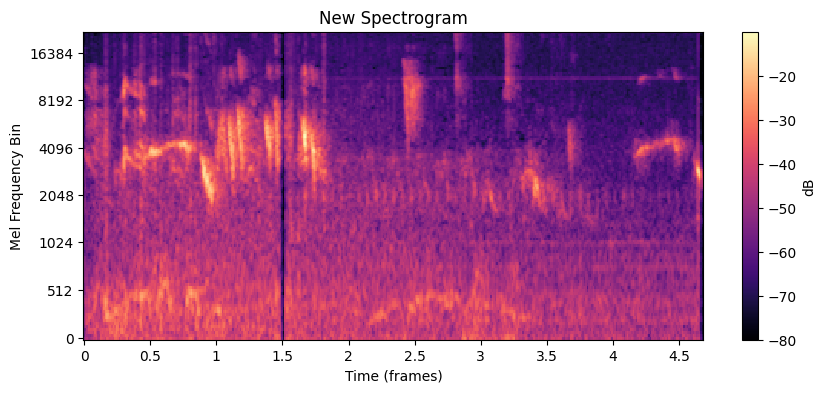

In [61]:
# Load the MP3 file directly
audio_path = '../data/raw_audio/sa_bird_audio/Black Cuckoo/Black_Cuckoo_01.mp3'
y, sr = librosa.load(audio_path, sr=44100)  # sr=None keeps the original sampling rate

# Trim leading and trailing silence (default threshold is -60 dB)
y, _ = librosa.effects.trim(y)  # you can adjust top_db threshold
#filter noise outside of bird song range
#y_filtered = bandpass_filter(y, sr)

# Compute the Mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmin=300, fmax=8000)  # You can adjust `n_mels`
spectrogram = librosa.power_to_db(S, ref=np.max)  # Convert to decibels
spectrogram = clip(spectrogram, 404)

base_path = '../data/processed_audio/flattened_npy_spectrograms/'

label_to_index = {label: index for index, label in enumerate(sorted(metadata['species'].unique()))}
print(label_to_index)


label_idx = label_to_index['Black Cuckoo']
label_onehot = np.zeros(len(label_to_index))
label_onehot[label_idx] = 1.0
print(label_onehot)

mix_idx = np.random.randint(0,len(mix_paths)) #get random spectrogram
mix_path = base_path + mix_paths[mix_idx]
mix_spec = np.load(mix_path).astype(np.float32)  
mix_spec = clip(mix_spec, 404) # clip since this is original spectrogram

#make one hot label for the mixup spectrogram
mix_label_idx = label_to_index[metadata['species'].iloc[mix_idx]]
mix_label_onehot = np.zeros(len(label_to_index))
mix_label_onehot[mix_label_idx] = 1.0

lam = np.random.beta(0.1, 0.1) #mixup ratio
lam=0.5
new_spectrogram = lam*spectrogram + (1-lam)*mix_spec
new_label = lam*label_onehot + (1-lam)*mix_label_onehot
print(new_label)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(spectrogram, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Original Spectrogram')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(mix_spec, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Spectrogram for Mixing')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(new_spectrogram, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('New Spectrogram')
plt.show()


#### Visualize Inject Background Noise


In [63]:
def resize_noise(noise, target_shape):
        """Resize noise to match the target spectrogram shape."""
        n_mels, time = target_shape
        noise_mels, noise_time = noise.shape

        # Time dimension
        if noise_time < time:
            repeats = (time // noise_time) + 1
            noise = np.tile(noise, (1, repeats))[:, :time]
        elif noise_time > time:
            noise = noise[:, :time]

        # Mel dimension
        if noise_mels < n_mels:
            noise = np.pad(noise, ((0, n_mels - noise_mels), (0, 0)))
        elif noise_mels > n_mels:
            noise = noise[:n_mels, :]

        return noise

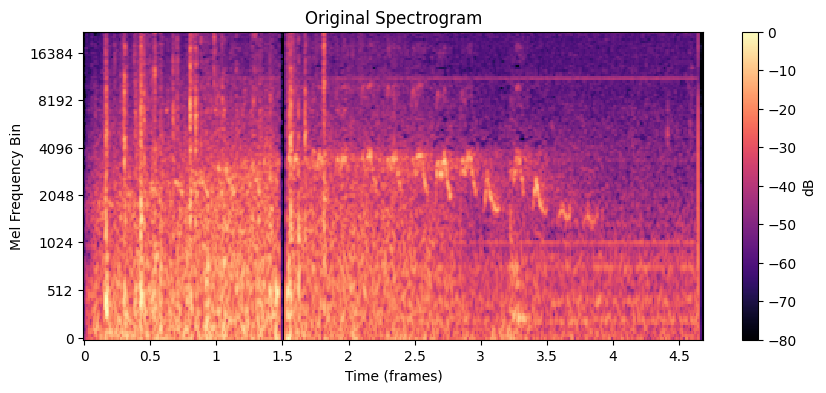

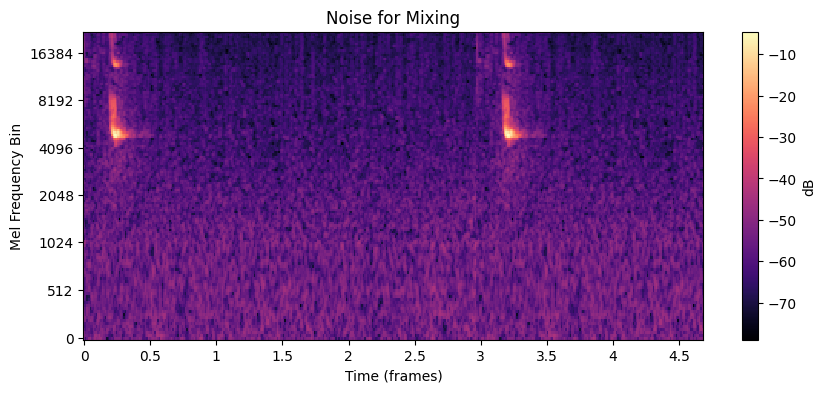

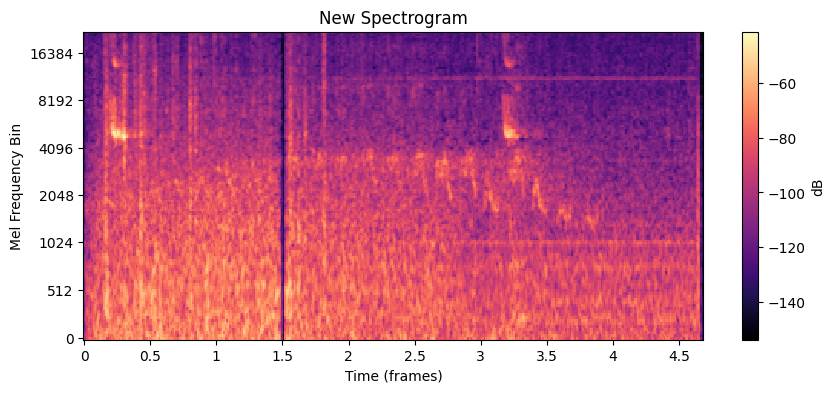

In [85]:
noise_dir = "../data/processed_audio/256f_chunked_spectrograms/noise"
noise_paths = [os.path.join(noise_dir, f) for f in os.listdir(noise_dir) if f.endswith('.npy')]

noise = np.load(random.choice(noise_paths))  # shape: should match spec
noise = resize_noise(noise, spectrogram.shape)
new_spectrogram = spectrogram + (1 * noise)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(spectrogram, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Original Spectrogram')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(noise, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Noise for Mixing')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(new_spectrogram, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('New Spectrogram')
plt.show()

#### Visualize Vertical Roll

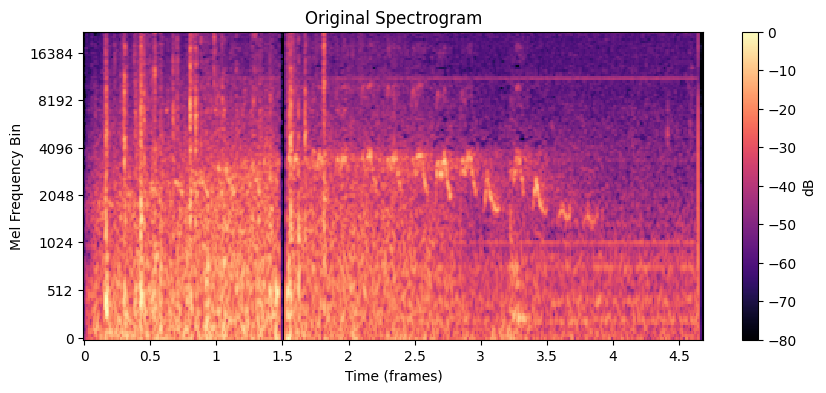

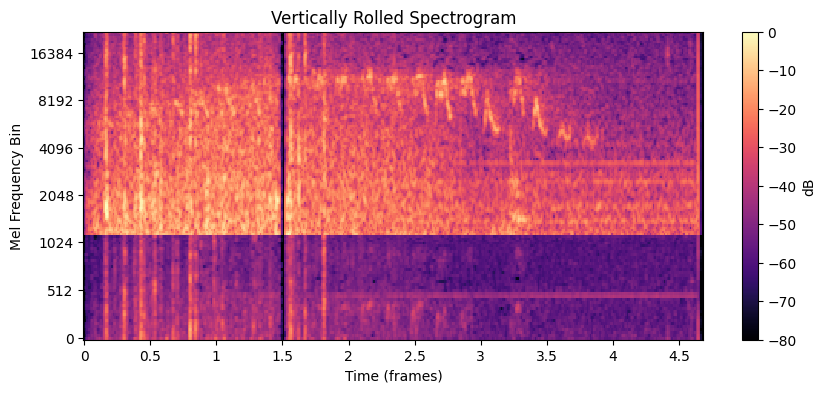

In [75]:
vertical = 0.4
v_shift = int(spectrogram.shape[0] * random.uniform(-vertical, vertical))
new_spectrogram = np.roll(spectrogram, v_shift, axis=0)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(spectrogram, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Original Spectrogram')
plt.show()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(new_spectrogram, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Vertically Rolled Spectrogram')
plt.show()

#### Visualize applying Gain

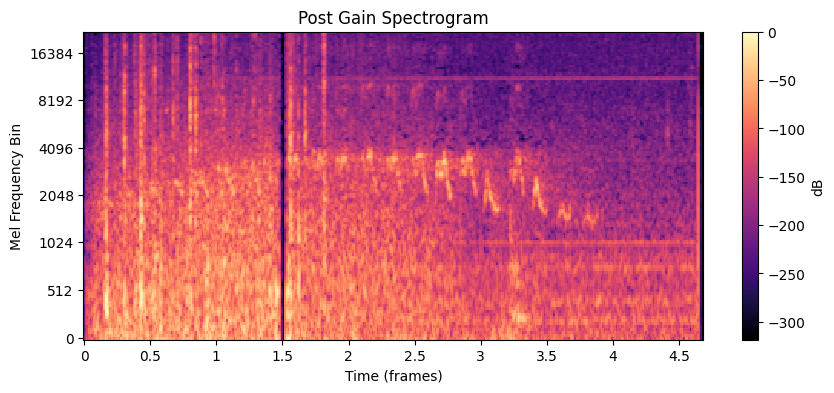

In [80]:
min_gain_db = -12.0
max_gain_db = 12.0

gain_db = 12
gain_linear = 10 ** (gain_db / 20)
new_spectrogram = spectrogram * gain_linear

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(new_spectrogram, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Post Gain Spectrogram')
plt.show()

#### Visualize Masking

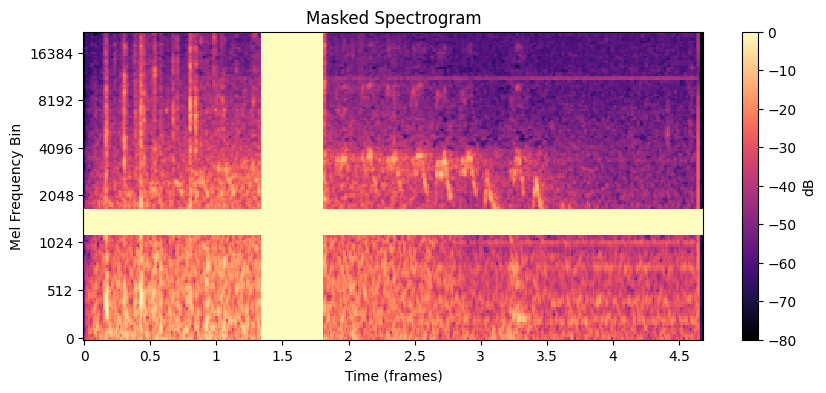

In [84]:
import numpy as np
import random

mask_percent = 0.1

masked = spectrogram.copy()
freq_bins, time_steps = masked.shape

# Time masking
time_mask_width = int(mask_percent * time_steps)
if time_mask_width > 0:
    start = random.randint(0, max(0, time_steps - time_mask_width))
    masked[:, start:start + time_mask_width] = 0

# Frequency masking
freq_mask_width = int(mask_percent * freq_bins)
if freq_mask_width > 0:
    start = random.randint(0, max(0, freq_bins - freq_mask_width))
    masked[start:start + freq_mask_width, :] = 0

# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(masked, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Masked Spectrogram')
plt.show()

In [ ]:


def mixup(spectrogram, label_onehot, mix_paths, alpha=1.0, p=0.5):
    if random.random() < p:
        mix_idx = np.random.randint(0,len(mix_paths)) #get random spectrogram from batch
        mix_path = mix_paths[mix_idx]
        mix_spec = np.load(mix_path).astype(np.float32)  # shape: [128, time]
        mix_spec = self.clip(mix_spec) # clip since this is original spectrogram

        #make one hot label for the mixup spectrogram
        mix_label_idx = label_to_index[labels[mix_idx]]
        mix_label_onehot = torch.zeros(self.num_classes, dtype=torch.float32)
        mix_label_onehot[mix_label_idx] = 1.0

        lam = np.random.beta(alpha, alpha) #mixup ratio
        spectrogram = lam*spectrogram + (1-lam)*mix_spec
        new_label = lam*label_onehot + (1-lam)*mix_label_onehot

        return spectrogram, new_label
    return spectrogram, label_onehot


def inject_background_noise(spectrogram, blend_factor, p=0.5):
    if random.random() < p:
        noise = np.load(random.choice(self.noise_paths))  # shape: should match spec
        if noise.shape != spectrogram.shape:
            noise = self._resize_noise(noise, spectrogram.shape)
        #add the noise and return
        return spectrogram + (blend_factor * noise)
    return spectrogram

def resize_noise(noise, target_shape):
    """Resize noise to match the target spectrogram shape."""
    n_mels, time = target_shape
    noise_mels, noise_time = noise.shape

    # Time dimension
    if noise_time < time:
        repeats = (time // noise_time) + 1
        noise = np.tile(noise, (1, repeats))[:, :time]
    elif noise_time > time:
        noise = noise[:, :time]

    # Mel dimension
    if noise_mels < n_mels:
        noise = np.pad(noise, ((0, n_mels - noise_mels), (0, 0)))
    elif noise_mels > n_mels:
        noise = noise[:n_mels, :]

    return noise

def inject_gaussian_noise(spectrogram, mean=0, min_std=0.001, max_std=0.015, p=0.5):
    if random.random() < p:
        std = np.random.uniform(min_std, max_std)
        noise = np.random.normal(mean, std, size=spectrogram.shape).astype(np.float32)
        return spectrogram + noise
    return spectrogram

def vertical_roll(spectrogram, vertical=0.1, p=0.5):
    if random.random() < p:
        v_shift = int(spectrogram.shape[0] * random.uniform(-vertical, vertical))
        spectrogram = np.roll(spectrogram, v_shift, axis=0)
        return spectrogram
    return spectrogram


def apply_gain(spectrogram, min_gain_db=-12.0, max_gain_db=12.0, p=0.5):
    if random.random() < p:
        gain_db = random.uniform(min_gain_db, max_gain_db)
        gain_linear = 10 ** (gain_db / 20)
        return spectrogram * gain_linear
    return spectrogram

def apply_masking(spectrogram, mask_percent=0.1, p=0.5):
    """Takes spectrogram as tensor. Applies masking from torchaudio library"""
    width = spectrogram.shape[-1]
    if random.random() < p:
        time_mask_param = mask_percent * width
        freq_mask_param = mask_percent * 128

        time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
        freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)

        spectrogram = freq_mask(spectrogram)
        spectrogram = time_mask(spectrogram)

    return spectrogram

In [4]:
# Load the MP3 file directly
audio_path = '../data/raw_audio/sa_bird_audio/Black Cuckoo/Black_Cuckoo_01.mp3'
y, sr = librosa.load(audio_path, sr=44100)  # sr=None keeps the original sampling rate

# Trim leading and trailing silence (default threshold is -60 dB)
y, _ = librosa.effects.trim(y)  # you can adjust top_db threshold
#filter noise outside of bird song range
#y_filtered = bandpass_filter(y, sr)

# Compute the Mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmin=300, fmax=8000)  # You can adjust `n_mels`
S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to decibels

### Visualize the Augmentations